In [9]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
def rbf_kernel(x1, x2, gamma=0.5):
    return np.exp(-gamma * np.linalg.norm(x1 - x2) ** 2)

In [3]:
class BinarySVM:
    def __init__(self, C=1.0, gamma=0.5, lr=0.001, n_iter=1000):
        self.C = C
        self.gamma = gamma
        self.lr = lr
        self.n_iter = n_iter

    def fit(self, X, y):
        self.X = X
        self.y = y
        n = X.shape[0]
        self.alpha = np.zeros(n)

        # matrice du noyau
        K = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                K[i, j] = y[i] * y[j] * rbf_kernel(X[i], X[j], self.gamma)

        # gradient ascent
        for _ in range(self.n_iter):
            grad = 1 - np.dot(K, self.alpha)
            self.alpha += self.lr * grad
            self.alpha = np.clip(self.alpha, 0, self.C)

        # calcul du biais b
        sv = (self.alpha > 1e-5)
        self.b = np.mean([
            y[i] - np.sum(self.alpha * y *
            np.array([rbf_kernel(X[i], X[j], self.gamma) for j in range(n)]))
            for i in range(n) if sv[i]
        ])

    def decision_function(self, X):
        scores = []
        for x in X:
            s = np.sum(self.alpha * self.y *
                np.array([rbf_kernel(x, xi, self.gamma) for xi in self.X]))
            scores.append(s + self.b)
        return np.array(scores)

    def predict(self, X):
        return np.sign(self.decision_function(X))


In [4]:
class SVM_OVR:
    def __init__(self, C=1.0, gamma=0.5):
        self.C = C
        self.gamma = gamma
        self.models = {}

    def fit(self, X, y):
        self.classes = np.unique(y)
        for c in self.classes:
            y_binary = np.where(y == c, 1, -1)
            svm = BinarySVM(C=self.C, gamma=self.gamma)
            svm.fit(X, y_binary)
            self.models[c] = svm

    def predict(self, X):
        scores = np.column_stack([
            self.models[c].decision_function(X)
            for c in self.classes
        ])
        return self.classes[np.argmax(scores, axis=1)]


In [5]:
def plot_decision_boundary(X, y, model):
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, h),
        np.arange(y_min, y_max, h)
    )

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
    plt.xlabel("Sepal length")
    plt.ylabel("Sepal width")
    plt.title("SVM à noyau RBF")
    plt.show()


Accuracy: 0.76


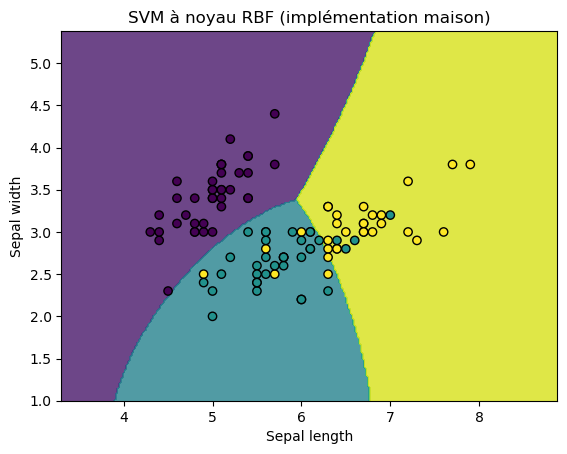

In [8]:
iris = datasets.load_iris()
X = iris.data[:, :2]
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

svm = SVM_OVR(C=1.0, gamma=0.5)
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

plot_decision_boundary(X_train, y_train, svm)
